# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

### Table of Contents

1. [Introduction - Business Problem](#introduction)
2. [Importing Libraries and Initial Setup](#setup)
3. [Data Collection, Exploration and Preprocessing](#data)
4. [Methodology](#method)
5. [Modelling and Analysis](#analysis)
6. [Results and Discussion](#result)
7. [Conclusion](#conclusion)


## 1. Introduction - Business Problem <a name="introduction"></a>

In this project, we will undertake the task of **identifying the best location to open a new Pizza Place in Bangalore, India**.

Bangalore, officially named Bengaluru, is the capital and the largest city of the Indian state of Karnataka. It has a population of more than 8 million, making it the third most populous city in India. Spread over an area of ~8000 square kilometers, the city has the unique distinction of having the highest elevation among all major cities of India. At a height of over 900 meters  above sea level, Bangalore is known for its pleasant climate throughout the year. Often referred to as the Silicon Valley of India, it is also the *second fastest growing major metropolis* in the country.

The rapid growth of the city provides a great number of lucrative business opportunities. While the city already has a vast number of restaurants spread across different localities and neighbourhoods, there are many new neighbourhoods coming up as a result of the expanding city limits. At the same time, there are new residential and commercial development projects across various locations. Both these factors combined give rise to unique business opportunities for entrepreneurs in the **hospitality and food services industry**.

In order to identify the most suitable location for opening a new restaurant, specifically a Pizzeria, we will follow these steps -

1. Collect data and analyze the various neighbourhoods across Bangalore
2. Identify similar neighbourhoods by categorizing them into clusters
3. Identify the clusters which typically have a high number of Pizza Places
4. Among those clusters, identify the neighbourhoods which have a scarcity of Pizza Places as compared to their respective clusters

## 2. Importing Libraries and Initial Setup <a name="setup"></a>

Before we can begin collecting data from various sources, we need to set up the development environment.

In [1]:
import pandas as pd
import numpy as np
import requests
import re
from bs4 import BeautifulSoup
import pgeocode
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
from pandas import json_normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Google API credentials
GOOGLE_API_KEY =  "AIza********"

# Foursquare API credentials
CLIENT_ID = "AQTJ********"
CLIENT_SECRET = "2EMV********"
VERSION = "20210101"

BANGALORE_NEIGHBOURHOODS = "bangalore_neighbourhoods.csv"
BANGALORE_VENUES = "bangalore_venues.csv"

sns.set_theme()
sns.set_style("white")

## 3. Data Collection and Exploration <a name="data"></a>

In the first stage of this project, we will collect the necessary data from various sources. 

1. We can get data on pincode-wise neighbourhoods in Bangalore from this website - https://finkode.com/ka/bangalore.html. We can use the **BeautifulSoup** library to extract data from the webpage and store it in a pandas dataframe.
2. Next, we can do some preliminary clean up of the data - filtering the relevant pincodes, cleaning neighbourhood names, removing/ combining duplicate pincodes into a single row, etc.
3. Once we have a clean set of neighbourhoods, we will use the **Google Maps API** to fetch coordinates for each of the neighbourhoods.
4. We can then use the **Folium** library to plot the map of Bangalore and visualize the neighbourhoods.



In [2]:
# This function takes as input an html table and returns a pandas dataframe
def readDataframeFromHTML(htmlTable):
    htmlRows = htmlTable.find_all("tr")
    dataRows = []
    for tr in htmlRows:
        htmlCells = tr.find_all(re.compile(r"(th|td)"))
        drow = []
        for td in htmlCells:
            try:
                drow.append(td.text.replace("\n", ""))
            except:
                continue
        if len(drow) > 0:
            dataRows.append(drow)

    df = pd.DataFrame(dataRows[1:], columns=dataRows[0])
    return (df)


In [3]:
# Read the html table into a dataframe from the given url using BeautifulSoup
pincodesURL = "https://finkode.com/ka/bangalore.html"
htmlPage = requests.get(pincodesURL)
soup = BeautifulSoup(htmlPage.text, "html.parser")
htmlTable = soup.find("table", attrs={"class":"plist"})
df = readDataframeFromHTML(htmlTable)
# Print the shape and first 5 rows of the raw dataframe
print("After parsing the table at {}, we have collected raw data for {} post offices in Bangalore.".format(pincodesURL, df.shape[0]))
df.head()

After parsing the table at https://finkode.com/ka/bangalore.html, we have collected raw data for 270 post offices in Bangalore.


,Post Office,District,Pincode
0,A F Station Yelahanka S.O,Bangalore,560063
1,Adugodi S.O,Bangalore,560030
2,Agara B.O,Bangalore,560034
3,Agram S.O,Bangalore,560007
4,Amruthahalli B.O,Bangalore,560092


In India, the Postal Index Number (PIN) is a 6 digit code to identify delivery post office of areas/ regions in India. There are 8 PIN regions in the country. The first digit indicates one of the regions. The first 2 digits together indicate the sub region or one of the postal circles. The first 3 digits together indicate a sorting / revenue district. The last 3 digits refer to the delivery Post Office.

For the purpose of this analysis, we will restrict our data to **Pincodes** starting with **560---**. We will also clean the neighbourhood names by removing *S.O* and *B.O* suffixes. Lastly, we will combine duplicate pincodes into a single row by concatenating the neighbourhood names of rows with the same pincodes.

In [4]:
# Convert Pincodes to int64
df["Pincode"] = df["Pincode"].astype("int64")
# Remove rows in which Pincode doesn't start with 560---
df = df[(df["Pincode"] >= 560001) & (df["Pincode"] <= 560999)]
# Remove S.O and B.O from post office names
df["Post Office"] = df["Post Office"].str.replace("S.O", "", regex=False).str.replace("B.O", "", regex=False).str.strip()
# Drop column District as it doesn't contain any relevant information
if "District" in df.columns: df.drop(columns=["District"], inplace=True)
# Combine duplicate pin code rows into a single row
duplicateCodes = df.groupby(by="Pincode").count().reset_index(drop=False)
if duplicateCodes[duplicateCodes["Post Office"] > 1].shape[0] > 0:
    df["Post Office"] = df.groupby(by="Pincode")["Post Office"].transform(lambda x: ','.join(x, ))
    df.drop_duplicates(inplace=True)
# Print the shape and first 5 rows of the clean dataframe
df.reset_index(drop=True, inplace=True)
# Rename column Post Office to Neighbourhood
df.columns = ["Neighbourhood", "Pincode"]
print("After preliminary clean up, we now have the pincodes for {} neighbourhoods in Bangalore.".format(df.shape[0]))
df.head()

After preliminary clean up, we now have the pincodes for 97 neighbourhoods in Bangalore.


,Neighbourhood,Pincode
0,"A F Station Yelahanka,BSF Campus Yelahanka",560063
1,Adugodi,560030
2,"Agara,Koramangala I Block,Koramangala,St. John...",560034
3,Agram,560007
4,"Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...",560092


We will now add the coordinates (latitude/ longitude) for each of these pincodes using Google API. *We will store this data into a csv file so that we don't need to repeatedly access the Google API for fetching this static data.*

In [5]:
# Function that takes as input an Indian address or pincode and returns the coordinates for that location
def getLatLngForPlace(address_or_pinCode):
    coords = {"Pincode": address_or_pinCode, "Latitude": None, "Longitude": None}
    api_key = GOOGLE_API_KEY
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    endpoint = f"{base_url}?address={address_or_pinCode},IN&key={api_key}"
    r = requests.get(endpoint)
    if r.status_code not in range(200, 299):
        return (coords)
    try:
        results = r.json()["results"][0]
        coords["Latitude"] = results["geometry"]["location"]["lat"]
        coords["Longitude"] = results["geometry"]["location"]["lng"]
    except:
        pass
    return (coords)

In [6]:
# Check if bangalore_neighbourhoods csv file already exists - we don't want to call google maps API if data is already saved
try:
    newDF = pd.read_csv(filepath_or_buffer=BANGALORE_NEIGHBOURHOODS)
except:
    # Get coordinates for each pincode
    newDF = df.copy(deep=True)
    allCoords = newDF["Pincode"].map(getLatLngForPlace)
    coordsDF = pd.DataFrame(allCoords.to_list())
    coordsDF["Pincode"] = coordsDF["Pincode"].astype("int64")
    # Combine the post office and coordinates into a new dataframe
    newDF = newDF.join(coordsDF.set_index("Pincode"), how="left", on="Pincode")
    newDF.to_csv(path_or_buf=BANGALORE_NEIGHBOURHOODS, index=False)

print("We have now added coordinates for each of the {} neighbourhoods.".format(newDF.shape[0]))
newDF.head()


We have now added coordinates for each of the 97 neighbourhoods.


,Neighbourhood,Pincode,Latitude,Longitude
0,"A F Station Yelahanka,BSF Campus Yelahanka",560063,13.129087,77.614226
1,Adugodi,560030,12.944150,77.607623
2,"Agara,Koramangala I Block,Koramangala,St. John...",560034,12.926138,77.622109
3,Agram,560007,12.957917,77.630912
4,"Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...",560092,13.064104,77.593121


In [7]:
# Check if the dataframe has any missing coordinates
invalidCoords = newDF[newDF["Latitude"].isna() | newDF["Longitude"].isna()]
print("A quick check of the data confirms that there are {} missing coordinates for the neighbourhoods.".format(invalidCoords.shape[0]))


A quick check of the data confirms that there are 0 missing coordinates for the neighbourhoods.


In [8]:
address = 'Bangalore, Karnatake, IN'
bangaloreCoords = getLatLngForPlace(address)
print('To create the folium map, we will also need coordinates of Bangalore - {}, {}.'.format(bangaloreCoords["Latitude"], bangaloreCoords["Longitude"]))

To create the folium map, we will also need coordinates of Bangalore - 12.9715987, 77.5945627.


We will write some functions that can be used to draw the **Folium** maps and add markers to the map based on the data collected. In the first visualization, we will draw the map of Bangalore and mark circles of 1 kilometer radius for each of the neighbourhoods. These are the areas that we will later use to collect data for the venues existing in each neighbourhood with the **Foursquare API**. 

In [9]:
# Simple function that returns a dictionary of colors for each value in the variable list
def getRangeOfColors(inputList):
    uniqueVals = inputList.unique()
    numColors = len(uniqueVals)
    colorsArray = sns.color_palette("Set2", numColors)
    rainbow = {}
    for i in range(numColors):
        rainbow[uniqueVals[i]] = colors.rgb2hex(colorsArray[i])
    return (rainbow)

In [10]:
# Function to create a folium map given location coordinates and marker data
def createFoliumMap(locLat, locLng, markerLats, markerLngs, markerColors, markerLabels, rainbow, zoomStart, showScale, showCircle, showCenter):
    fig = folium.Figure(width=800, height=500)
    # create map of Toronto using latitude and longitude values
    mapObject = folium.Map(location=[locLat, locLng], tiles="OpenStreetMap", zoom_start=zoomStart, control_scale = showScale)
    # add markers to map
    for lat, lng, clr, lbl in zip(markerLats, markerLngs, markerColors, markerLabels):
        label = folium.Popup('{}, {}'.format(lbl, clr), parse_html=True)
        if showCircle:
            folium.Circle([lat, lng], radius=1000, color="none", fill=True, fill_color=rainbow[clr], fill_opacity=0.7, parse_html=False).add_to(mapObject)
        if showCenter:
            folium.CircleMarker([lat, lng], radius=5, popup=label, color="none", fill=True, fill_color=rainbow[clr], fill_opacity=1, parse_html=False).add_to(mapObject)

    fig.add_child(mapObject)
    return (fig)

In [11]:
createFoliumMap(
    locLat=bangaloreCoords["Latitude"], 
    locLng=bangaloreCoords["Longitude"], 
    markerLats=newDF["Latitude"], 
    markerLngs=newDF["Longitude"], 
    markerColors=newDF["Pincode"], 
    markerLabels=newDF["Neighbourhood"], 
    rainbow=getRangeOfColors(newDF["Pincode"]),
    zoomStart=10, showScale=True, showCircle=True, showCenter=True
)

Once we have visualized the neighbourhood locations on the map, we can use the **Foursquare API** to fetch data for all the venues located within each neighbourhood. We will use the **explore** API call to get venues within 1 kilometer radius of the coordinates of each neighbourhood. We should be aware of the fact that this method will not provide an exact list of venues within each neighbourhood as the actual shape of the neighbourhood will not be a circle. Hence, we will most likely miss out on venues that are not within the 1 kilometer radius. Also, there would be possible duplications of venues between neighbourhoods that are less than 1 kilometer apart.

A more accurate way to map venues to each neighbourhood would be to get their real boundaries and then check if a particular venue lies within those bounds. Since we don't have access to  boundary data, we will defer that analysis for a later time.

In [12]:
# function that extracts the category of the venue
def getVenueCategory(row):
    try:
        categoriesList = row['categories']
    except:
        categoriesList = row['venue.categories']
        
    if len(categoriesList) == 0:
        return None
    else:
        return (categoriesList[0]['name'])

In [13]:
# function that takes the coordinates of a neighbourhood and returns a list of venues that lie within a certain radius of that center
def getVenuesForNeighbourhood(neighLatitude, neighLongitude, neighRadius = 1000, maxLimit = 100):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighLatitude, 
        neighLongitude, 
        neighRadius, 
        maxLimit)
    try:
        results = requests.get(url).json()
        # Convert the results json into a dataframe
        venues = results["response"]["groups"][0]["items"]
        nearbyVenues = json_normalize(venues) # flatten JSON
        filteredColumns = ["venue.name", "venue.categories", "venue.location.lat", "venue.location.lng"]
        nearbyVenues = nearbyVenues.loc[:, filteredColumns]
        # Set the column names by removing "venue." from the names
        nearbyVenues["venue.categories"] = nearbyVenues.apply(getVenueCategory, axis=1)
        nearbyVenues.columns = [col.split(".")[-1] for col in nearbyVenues.columns]
        return (nearbyVenues)
    except:
        return None

In [14]:
# function that takes as input all the neighbourhood coordinates and returns the complete dataframe of all venues
def getCompleteVenueList(names, latitudes, longitudes):
    venuesDF = pd.DataFrame()
    for name, lat, lng in zip(names, latitudes, longitudes):
        neighVenues = getVenuesForNeighbourhood(lat, lng)
        if neighVenues is None:
            print("No venues were found for {}.".format(name))
        else:
            neighVenues.insert(loc=0, column="neigh", value=name)
            venuesDF = venuesDF.append(pd.DataFrame(neighVenues))
    venuesDF.reset_index(drop=True)
    venuesDF.columns = ["Neighbourhood", "Venue", "Category", "Venue Latitude", "Venue Longitude"]
    return (venuesDF)

Using the **Foursquare API**, we can now get a complete list of all venues within the neighbourhoods of Bangalore. The data will contain the venue name, category and exact coordinates.

In [15]:
try:
    allVenues = pd.read_csv(filepath_or_buffer=BANGALORE_VENUES)
except:
    allVenues = getCompleteVenueList(names=newDF["Neighbourhood"], latitudes=newDF["Latitude"], longitudes=newDF["Longitude"])
    allVenues.to_csv(path_or_buf=BANGALORE_VENUES, index=False)
print("We found {} venues across {} neighbourhoods.".format(allVenues.shape[0], len(allVenues["Neighbourhood"].unique())))
allVenues.head()

We found 2303 venues across 94 neighbourhoods.


,Neighbourhood,Venue,Category,Venue Latitude,Venue Longitude
0,"A F Station Yelahanka,BSF Campus Yelahanka",Hunsmarnahalli lake,Lake,13.124539,77.612036
1,"A F Station Yelahanka,BSF Campus Yelahanka",AERO INDIA 2017,Hot Spring,13.132061,77.608366
2,"A F Station Yelahanka,BSF Campus Yelahanka",Food City,Department Store,13.121693,77.612900
3,"A F Station Yelahanka,BSF Campus Yelahanka",Tandoori Bites,Indian Restaurant,13.121500,77.614900
4,"A F Station Yelahanka,BSF Campus Yelahanka",Jodhpur sweets,Indian Restaurant,13.121311,77.615280


A quick inspection of the data shows how many venues we have for each neighbourhood. For the sake of this analysis, we have restricted the maximum number of venues to 100.

In [16]:
allVenues.loc[:,["Neighbourhood", "Venue"]].groupby("Neighbourhood").count().sort_values(by="Venue", ascending=False).reset_index()

,Neighbourhood,Venue
0,"Bangalore Bazaar,Bangalore G.P.O.,Cubban Road,...",100
1,Indiranagar (Bangalore),100
2,"CMP Centre And School,Museum Road,Richmond Town",100
3,HSR Layout,80
4,"Jayangar III Block,Madhavan Park",79
...,...,...
89,Nayandahalli,4
90,Jalahalli East,3
91,"Haragadde,Hennagara,Hulimangala,Jigani",3
92,"Bnagalore Viswavidalaya,Mallathahalli,Ullalu U...",2


We will now explore the various categories of the venues. We can plot a bar graph to see which are the most common categories and the distribution of venues across those categories.

There are 228 uniques categories.


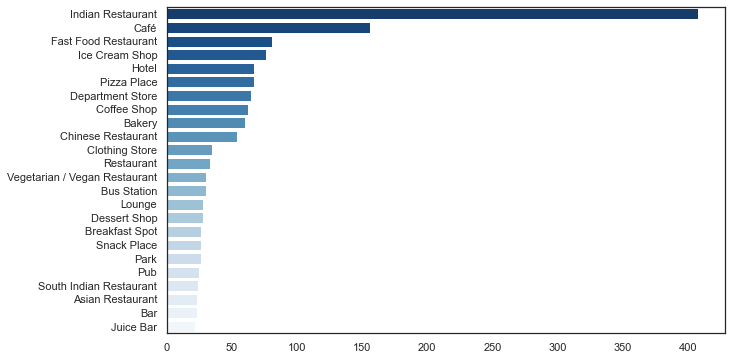

In [17]:
categoriesDF = allVenues.loc[:,["Category", "Venue"]].groupby(by="Category").count().sort_values(by="Venue", ascending=False).reset_index()

print("There are {} uniques categories.".format(categoriesDF.shape[0]))

plt.figure(figsize=(10, 6))
sns.barplot(x="Venue", y="Category", data=categoriesDF.iloc[0:24,], palette="Blues_r")
plt.xlabel("")
plt.ylabel("")
plt.show()

We can see from the bar graph that **Indian Restaurant** is the most common category of venue. It is also clear that a large number of venues are different categories of restaurants and eateries. Besides these, there are hotels, department stores and clothing stores that are quite common. 

Since we are interested in opening a **Pizzeria**, the category that is most relevant to our analysis is **Pizza Place**. We will use this as the category when assessing suitability of neighbourhoods for opening a new restaurant. 

## 4. Methodology <a name="method"></a>

We have now collected the data that is required for our analysis. The next step is to formulate a methodology to use that data in order to solve the business requirement. In this case, we are interested in finding out which neighbourhoods are most suitable for opening a new **Pizza Place** in Bangalore. To do that, we will first cluster the 94 neighbourhoods in our dataset on the basis of the types of venues that are found in each of them. Using **K-means Clustering**, we will find out which neighbourhoods are most similar to each other.

Next, we will identify the clusters of neighbourhoods which have the maximum number of **Pizza Places** within their vicinity. These clusters of neighbourhoods would be the ones that are **most likely to have characteristics that can result in a successful restaurant business**. 

Finally, within those clusters, we will identify neighbourhoods which don't have enough number of **Pizza Places**. Based on their similarity to neighbourhoods with a high number of successful Pizzerias, we can argue that these neighbourhoods are also **good candidates** for opening a new Pizzeria.

For the clustering algorithm, we need a dataframe containing each neighbourhood as a single row and the columns containing the number of venues for each category. 

In [18]:
# Use one-hot encoding to convert the venues data into a dataframe of neighbourhoods and the average weight each category within those neighbourhoods
venuesOnehot = pd.get_dummies(allVenues[["Category"]], prefix="", prefix_sep="")
venuesOnehot.insert(loc=0, column="Neighbourhood", value=allVenues["Neighbourhood"])
# Group the venues by neighbourhood and calculate the average for each category
venuesGrouped = venuesOnehot.groupby("Neighbourhood").mean().reset_index()
venuesGrouped.head()

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Andhra Restaurant,Arcade,...,Tram Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"A F Station Yelahanka,BSF Campus Yelahanka",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,Adugodi,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"Agara,Koramangala I Block,Koramangala,St. John...",0.0,0.0,0.0,0.0,0.0,0.0,0.017544,0.017544,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017544
3,Agram,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.031250,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Using the data above, we can compare neighbourhoods for similarity based on the type of venues found in each of them. For instance, we can see that, of all the venues in *Amruthahalli,Byatarayanapura...* neighbourhood, 3.125% are *Andhra Restaurants*. Thus, we have a composition of venues by category for each neighbourhood. The neighbourhoods with similar compositions will be put into the same cluster.

We can also do a quick review of the most common venues across some of the neighbourhoods to validate the data.

In [19]:
def getMostCommonVenues(row, numTopVenues):
    rowCategories = row.iloc[1:]
    rowCategoriesSorted = rowCategories.sort_values(ascending=False)
    return rowCategoriesSorted.index.values[0:numTopVenues]

In [20]:
numTopVenues = 5
indicators = ["st", "nd", "rd"]
columns = ["Neighbourhood"]
for ind in np.arange(numTopVenues):
    try:
        columns.append("{}{} Most Common Venue".format(ind+1, indicators[ind]))
    except:
        columns.append("{}th Most Common Venue".format(ind+1))

neighVenuesSorted = pd.DataFrame(columns=columns)
neighVenuesSorted["Neighbourhood"] = venuesGrouped["Neighbourhood"]

for ind in np.arange(venuesGrouped.shape[0]):
    neighVenuesSorted.iloc[ind, 1:] = getMostCommonVenues(venuesGrouped.iloc[ind, :], numTopVenues)

neighVenuesSorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"A F Station Yelahanka,BSF Campus Yelahanka",Indian Restaurant,Hot Spring,Lake,Department Store,Movie Theater
1,Adugodi,Café,Spa,Tea Room,Kerala Restaurant,Nightclub
2,"Agara,Koramangala I Block,Koramangala,St. John...",Indian Restaurant,Café,Pub,Coffee Shop,Ice Cream Shop
3,Agram,Pizza Place,Historic Site,Indian Restaurant,Golf Course,Nightclub
4,"Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...",Indian Restaurant,Ice Cream Shop,Bus Station,Resort,Fast Food Restaurant
5,"Anandnagar (Bangalore),H.A. Farm,Hebbal Kempa...",Bus Station,Ice Cream Shop,Fast Food Restaurant,Lake,Gym
6,"Arabic College,Nagawara,Venkateshapura",Indian Restaurant,Department Store,Optical Shop,ATM,North Indian Restaurant
7,"Ashoknagar (Bangalore),Banashankari,Dasarahal...",Indian Restaurant,Department Store,Park,Athletics & Sports,Snack Place
8,"Attur,CRPF Campus Yelahanka,Jakkur,Rajanakunte...",Café,Indian Restaurant,Train Station,Smoke Shop,Food Truck
9,"Austin Town,Viveknagar (Bangalore)",Clothing Store,Café,Park,Spa,Indian Restaurant


## 5. Modelling and Analysis <a name="analysis"></a>

Given that we have a dataframe containing the features of each neighbourhood, we can now use this dataframe to build our **K-means clustering model**. We will run the algorithm for multiple values of *k*, and select the one with the highest **Silhouette Coefficient**. We will also plot the sum of squared errors and silhouette coefficients for each value of k.

In [21]:
def plotKMeansErrors(sse, silhouetteCoefs, ks):    
    
    fig = plt.figure(figsize=(12, 9))
    sns.set_theme()
    sns.set_style("white")

    fig.add_subplot(2,1,1)
    sns.lineplot(x = ks, y = sse)
    plt.xticks(ks)
    plt.ylabel("SSE")
    
    fig.add_subplot(2,1,2)
    sns.lineplot(x = ks, y = silhouetteCoefs)
    plt.xticks(ks)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.axvline(x = ks[np.argmax(silhouetteCoefs)], linestyle='dotted')

    plt.show()

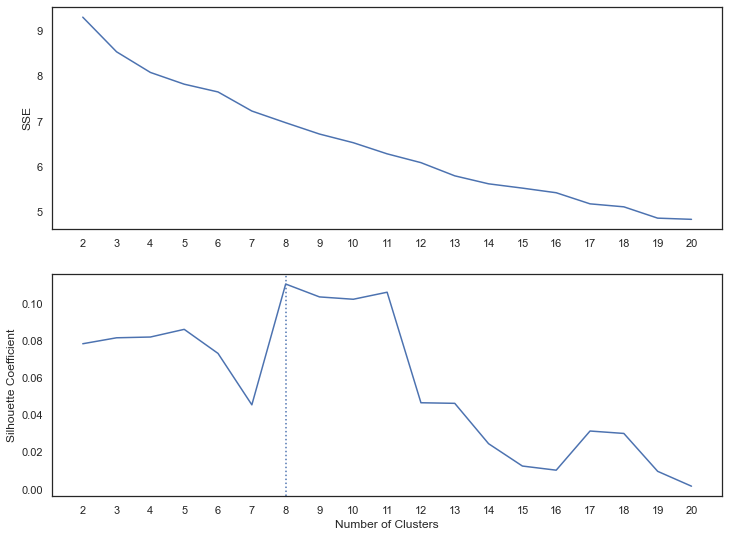

In [22]:
venuesGroupedClustering = venuesGrouped.drop("Neighbourhood", 1)
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42 }
# A list holds the SSE values for each k
sse = []
silhouetteCoefs = []
ks = range(2, 21)
for k in ks:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(venuesGroupedClustering)
    sse.append(kmeans.inertia_)
    score = silhouette_score(venuesGroupedClustering, kmeans.labels_)
    silhouetteCoefs.append(score)

plotKMeansErrors(sse, silhouetteCoefs, ks)

Looking at the **Silhouette Coefficients**, we can choose **k = 8** for our final model.

In [23]:
# set number of clusters
kclusters = ks[np.argmax(silhouetteCoefs)]
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(venuesGroupedClustering)
# check cluster labels generated for each row in the dataframe
print("Sample set of first 10 labels >> {}".format(kmeans.labels_[0:10]))

Sample set of first 10 labels >> [7 3 1 7 7 0 7 0 1 5]


The model is now trained on the neighbourhood data and we have identified the cluster number for each neighbourhood. There are 8 clusters in total and each neighbourhood is assigned a cluster number between 0-7. We will now add these cluster numbers to our original dataframe for further analysis.

In [24]:
# add clustering labels
clusterLabelCol = "Cluster Labels"
if clusterLabelCol in neighVenuesSorted.columns:
    neighVenuesSorted.drop(labels=clusterLabelCol, axis=1, inplace=True)
neighVenuesSorted.insert(loc=0, column=clusterLabelCol, value=kmeans.labels_)
mergedDF = newDF
# merge with original neighbourhood data
mergedDF = mergedDF.join(neighVenuesSorted.set_index("Neighbourhood"), on="Neighbourhood", how="inner")
mergedDF.head()

,Neighbourhood,Pincode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"A F Station Yelahanka,BSF Campus Yelahanka",560063,13.129087,77.614226,7,Indian Restaurant,Hot Spring,Lake,Department Store,Movie Theater
1,Adugodi,560030,12.944150,77.607623,3,Café,Spa,Tea Room,Kerala Restaurant,Nightclub
2,"Agara,Koramangala I Block,Koramangala,St. John...",560034,12.926138,77.622109,1,Indian Restaurant,Café,Pub,Coffee Shop,Ice Cream Shop
3,Agram,560007,12.957917,77.630912,7,Pizza Place,Historic Site,Indian Restaurant,Golf Course,Nightclub
4,"Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...",560092,13.064104,77.593121,7,Indian Restaurant,Ice Cream Shop,Bus Station,Resort,Fast Food Restaurant


In order to visualize the clusters of neighbourhoods, we will use a Folium map. A marker is added for each neighbourhood and the color of the marker will depend on the cluster number.

In [25]:
clusterRainbow = getRangeOfColors(mergedDF["Cluster Labels"])
createFoliumMap(
    locLat=bangaloreCoords["Latitude"], 
    locLng=bangaloreCoords["Longitude"], 
    markerLats=mergedDF["Latitude"], 
    markerLngs=mergedDF["Longitude"], 
    markerColors=mergedDF["Cluster Labels"], 
    markerLabels=mergedDF["Neighbourhood"], 
    rainbow=clusterRainbow,
    zoomStart=11, showScale=True, showCircle=True, showCenter=True
)

For our final analysis, we will now add the Cluster Labels to the venue data. We will then analyze which clusters of neighbourhoods typically have a high ratio of Pizza Places located in their vicinities. Finally, we will try to shortlist neighbourhoods within those clusters which don't have a sufficient number of pizza places.

In [26]:
labeledVenues = allVenues.join(other=mergedDF[["Neighbourhood", clusterLabelCol]].set_index("Neighbourhood"), on="Neighbourhood", how="left")
labeledVenues.head()

,Neighbourhood,Venue,Category,Venue Latitude,Venue Longitude,Cluster Labels
0,"A F Station Yelahanka,BSF Campus Yelahanka",Hunsmarnahalli lake,Lake,13.124539,77.612036,7
1,"A F Station Yelahanka,BSF Campus Yelahanka",AERO INDIA 2017,Hot Spring,13.132061,77.608366,7
2,"A F Station Yelahanka,BSF Campus Yelahanka",Food City,Department Store,13.121693,77.612900,7
3,"A F Station Yelahanka,BSF Campus Yelahanka",Tandoori Bites,Indian Restaurant,13.121500,77.614900,7
4,"A F Station Yelahanka,BSF Campus Yelahanka",Jodhpur sweets,Indian Restaurant,13.121311,77.615280,7


In [27]:
pizzaVenues = labeledVenues[labeledVenues["Category"] == "Pizza Place"]
createFoliumMap(
    locLat=bangaloreCoords["Latitude"], 
    locLng=bangaloreCoords["Longitude"], 
    markerLats=pizzaVenues["Venue Latitude"], 
    markerLngs=pizzaVenues["Venue Longitude"], 
    markerColors=pizzaVenues["Cluster Labels"], 
    markerLabels=pizzaVenues["Venue"], 
    rainbow=clusterRainbow,
    zoomStart=11, showScale=True, showCircle=False, showCenter=True
)

From the map above which shows the location of each Pizza Place and the color of its respective cluster, it is evident that most of these pizzerias are in the Blue (1), Green (7) and Pink (0) clusters. We can further quantify this by calculating the number of Pizza places in each neighbourhood within a cluster and compare that to the total number of venues in that neighbourhood.

In [28]:
minVenueCount = 10

candidateClusters = pizzaVenues[[clusterLabelCol, "Venue"]].groupby(by=clusterLabelCol).count().join(
    other=labeledVenues[[clusterLabelCol, "Category"]].groupby(by=clusterLabelCol).count(), how="left"
    ).join(
        other=mergedDF[[clusterLabelCol, "Neighbourhood"]].groupby(by=clusterLabelCol).count(), how="left"
    ).reset_index().fillna(0)
candidateClusters.columns = [clusterLabelCol, "Pizza Venues", "Total Venues", "Total Neighbourhoods"]
candidateClusters["Avg. Pizza Venues"] = candidateClusters["Pizza Venues"] / candidateClusters["Total Venues"]
candidateClusters["Avg. Venues"] = candidateClusters["Total Venues"] / candidateClusters["Total Neighbourhoods"]
candidateClusters = candidateClusters.loc[candidateClusters["Avg. Venues"] >= minVenueCount]
candidateClusters

,Cluster Labels,Pizza Venues,Total Venues,Total Neighbourhoods,Avg. Pizza Venues,Avg. Venues
0,0,8,225,16,0.035556,14.062500
1,1,43,1491,44,0.028840,33.886364
3,7,13,554,26,0.023466,21.307692


From the table above, we can see that Clusters 0, 1 and 7 have most of the Pizza Places located within their neighbourhoods. So these clusters are the ideal candidates for opening a new restaurant. We can also see that the average number of venues in each of these neighbourhoods varies between ~14 to ~34. This implies that **Cluster 1**, which has the highest number of average venues, probably belongs to the most densely populated areas in the city. Similarly, **Cluster 0** has the lowest number of venues per neighbourhood implying that these areas may be the newly developed or upcoming localities of the city.

*Note that we have ignored clusters which have fewer than 10 venues per neighbourhood - the reason is that these clusters may be too sparse in terms of venue data for us to be able to analyze them properly.*

In [29]:
candidateNeighbourhoods = labeledVenues.loc[labeledVenues[clusterLabelCol].isin(candidateClusters[clusterLabelCol]), [clusterLabelCol, "Neighbourhood", "Venue"]].groupby(
    by=[clusterLabelCol, "Neighbourhood"]).count().join(
        pizzaVenues[["Neighbourhood", clusterLabelCol, "Category"]].groupby(by=[clusterLabelCol, "Neighbourhood"]).count(), how="left"
    ).reset_index().fillna(0).join(
        candidateClusters[[clusterLabelCol, "Avg. Pizza Venues", "Avg. Venues"]].set_index(clusterLabelCol), on=clusterLabelCol, how="left"
        )
candidateNeighbourhoods.columns = [clusterLabelCol, "Neighbourhood", "Total Venues","Pizza Venues", "Avg. Pizza Venues", "Avg. Venues"]
candidateNeighbourhoods["Exp. Pizza Venues"] = candidateNeighbourhoods["Total Venues"] * candidateNeighbourhoods["Avg. Pizza Venues"]
candidateNeighbourhoods = candidateNeighbourhoods[
    (candidateNeighbourhoods["Total Venues"] > 0) 
    & (candidateNeighbourhoods["Total Venues"] > candidateNeighbourhoods["Avg. Venues"]) 
    & (candidateNeighbourhoods["Pizza Venues"] < candidateNeighbourhoods["Avg. Pizza Venues"])
].sort_values(by="Exp. Pizza Venues", ascending=False).reset_index(drop=True)
candidateNeighbourhoods

,Cluster Labels,Neighbourhood,Total Venues,Pizza Venues,Avg. Pizza Venues,Avg. Venues,Exp. Pizza Venues
0,1,Sivan Chetty Gardens,73,0.0,0.028840,33.886364,2.105298
1,7,"Jeevabhimanagar,Jeevanbhimanagar,New Thippasandra",47,0.0,0.023466,21.307692,1.102888
2,7,"Bangalore Dist Offices Bldg,K. G. Road",38,0.0,0.023466,21.307692,0.891697
3,0,"Ashoknagar (Bangalore),Banashankari,Dasarahal...",22,0.0,0.035556,14.062500,0.782222
4,7,Chickpet,28,0.0,0.023466,21.307692,0.657040
5,7,"Sampangiramnagar,Shanthinagar,Wilson Garden",25,0.0,0.023466,21.307692,0.586643


This concludes our analysis. From the table above, we can see that there are 6 possible candidate neighbourhoods which are suitable to opening a new Pizzeria in Bangalore. The strongest candidate neighbourhood is **Sivan Chetty Gardens**, which falls within **Cluster 1**. Based on the number of venues in this neighbourhood, there are expected to be ~2 Pizza Places here. But currently, there are none.


## 6. Results and Discussion <a name="result"></a>

We have completed our analysis of the neighbourhoods of Bangalore and presented our findings above. We looked at 94 neighbourhoods across the city and were able to identify the most suitable locations for opening a new pizzeria based on the characteristics of each neighbourhood combined with the presence or absence of competitors in each area. We have thus identified **Sivan Chetty Gardens** as the best neighbourhood to open a new pizzeria in Bangalore.

Our final result includes a list of 6 neighbourhoods which are most suitable for opening a new pizzeria. We have presented this list in the order of most suitable to least based on the expected number of pizzerias that should *ideally be present in these neighbourhoods*. But given that there are many other factors that may go into deciding the suitability of a location, we believe that it is best to review each of these 6 neighbourhoods in further detail. This may require on-the-ground surveys and collecting other relevant data such as property prices, total population, average age and income demographics, residential vs. commercial developments in the area, etc.

We would also like to highlight the fact that this analysis is based on the data available with Foursquare for the city of Bangalore, India. It is likely that this data does not represent the complete set of venues and, given a more accurate source, the results of the analysis may vary. It is also important to highlight that this analysis doesn't take into consideration a number of important factors (such as population demographics... listed above) that would impact the final decision. As a next step, it would be advisable to include more features for each neighbourhood in order to create more accurate clusters.

## 7. Conclusion <a name="conclusion"></a>

The purpose of this analysis was to identify the most suitable neighbourhood for opening a pizzeria in Bangalore. We have successfully achieved this outcome.

We have collated data from multiple sources, identified the characteristics of neighbourhoods across Bangalore and used K-means clustering to find similar neighbourhoods. We then analyzed these clusters for suitable candidates and finally shortlisted the neighbourhoods which are most suitable for opening a new restaurant.

We have also provided the pros and cons of each of these final neighbourhoods. Some of them are already densely populated or established localities where there are no competing pizzerias. Others are less densely populated and are likely to be new and upcoming neighbourhoods. Based on this information and further on-the-ground surveys, the relevant stakeholders can decide on the final location for the new pizzeria.